#### Several works in the field of automatic tumor diagnosis can be divided into two main categories, namely feature extraction and sample classification. 
#### In general, the image properties are extracted first. These features usually include static features such as entropy, skewness, mean, energy, torque, and correlation or properties obtained by applying other algorithms

In [1]:
import numpy as np
import keras
import tensorflow as tf
import cv2
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

import os
import cv2
import numpy as np
from skimage import io, img_as_ubyte
from kapur import kapur_threshold

from matplotlib import pyplot as plt
from skimage import io, img_as_ubyte
from kapur import kapur_threshold

from PIL import Image
from tensorflow.keras.layers import Conv2D, Input, GlobalAveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Model, load_model, save_model

from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import backend

from keras import applications
from keras.models import Sequential



### 0. Data Augmentation

In [34]:
def create_dir(newdir, empty = True):
    """
    create new folder if the target folder doesnt exist
    """
    CHECK_FOLDER = os.path.isdir(newdir)
    # If folder doesn't exist, then create it.
    if not CHECK_FOLDER:
        os.makedirs(newdir)
        print("created folder : ", newdir)

    else:
        if empty == True:
            ## whether to remove all contents in the current augmented data folder and generate new ones
            shutil.rmtree(newdir)
            print("current augmented data removed")
            os.makedirs(newdir)
            
        print(newdir, "folder already exists.")
    
## save the augmented data and the original ones in new folders
def data_augmentation(refresh = True, num = 5):
    """refresh: whether to replace current augmented data and generate new ones
    num: number of augmented data per image"""

    
    training_path = "data\\Training"
    ## destination parent folder for augmented data
    augmented_path = "data\\augmentation_training"
    current_directory = os.getcwd()
    original_path = os.path.join(current_directory,training_path)
    augmented_path = os.path.join(current_directory,augmented_path)

    ## augmented data generator
    image_generator = ImageDataGenerator(rotation_range = 90, shear_range = 0.4,zoom_range = 0, samplewise_center=True, 
                                         vertical_flip = True, horizontal_flip = True, samplewise_std_normalization= True)
    for subf in  os.listdir(original_path):
        
        new_dir = os.path.join(augmented_path, subf)
        create_dir(new_dir, empty = refresh)
        for f in os.listdir(os.path.join(original_path, subf)):
            image_path = os.path.join(original_path, subf,f)
            img = load_img(image_path)  
            i = 1
            img.save(os.path.join(augmented_path, subf, f))
            for batch in image_generator.flow(x, batch_size = 1, 
                          save_to_dir = new_dir,  
                          save_prefix = f.split(".")[0], save_format ='jpg'):
                i += 1
                if i > num: 
                    break

In [204]:
data_augmentation()

current augmented data removed
D:\project\data\augmentation_training\notumor folder already exists.
created folder :  D:\project\data\augmentation_training\pituitary


### 1. Image Preprocessing

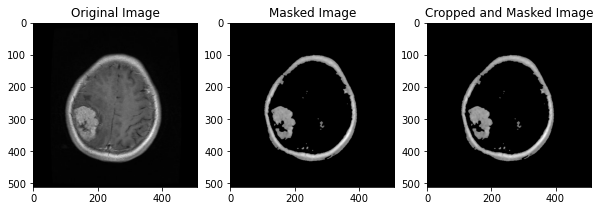

In [31]:

import imutils
def blur_and_crop(image, blur = "median", cropping= False, kernel = 5, masking = True, plot=False):
    """
    preprocessing:
    1. convert to grayscale and blur the image using median or gaussian filter
    2. (optional)apply kapur thresholding to create a mask, mask the blurred image
    3. crop the image to contain only the brain image, leaving the blank around surrounding the brain out.
    """
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if blur == "median":
        blurred = cv2.medianBlur(gray, kernel)
    elif blur == "gaussian":
        blurred = cv2.GaussianBlur(gray, (kernel, kernel), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise

    if masking == True:
   ## creating mask with kapur thresholding
        threshold = kapur_threshold(blurred)
        binr = cv2.threshold(blurred, threshold, 255, cv2.THRESH_BINARY)[1]
        masked_image = cv2.bitwise_and(blurred, blurred, mask=binr)
    else:
        masked_image = blurred
    if cropping == True:

        thresh = cv2.threshold(masked_image, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # Find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)


        # Find the extreme points for cropping
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # crop new image out of the original image using the four extreme points (left, right, top, bottom)
        cropped_image = masked_image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]      
    else:
        cropped_image = masked_image

    if plot:
        plt.figure(figsize=(10, 10))
        plt.subplot(131), plt.imshow(image, cmap='gray'), plt.title('Original Image')
        plt.subplot(132), plt.imshow(masked_image, cmap='gray'), plt.title('Masked Image')
        plt.subplot(133), plt.imshow(cropped_image, cmap='gray'), plt.title('Cropped and Masked Image')
        
        plt.show()
    

    return cropped_image

img = cv2.imread(r"D:\project\data\Training\meningioma\Tr-me_0011.jpg")
new_img = blur_and_crop(img, blur = "median", cropping = False, kernel = 5, masking = True, plot=True)


In [17]:
training_path = "data\\Training"
"\\augmentation_".join(training_path.split("\\"))

'data\\augmentation_Training'

In [32]:
def preprocessing(training_path, masking = False, crop = False):
    """
    preprocess the images in training_path parent folder
    1. create a destination folder for preprocessed images
    2. blur, mask and (crop) the iamges, masking is optional.
    3. store the processed images in new folder
    
    parameter: 
    training_path: the folder name for the original images to be processed
    masking: if masking is applied in the processing
    """
    
    current_directory = os.getcwd()
    ## destination parent folder for processed data
    if masking == True:
        processed_path = "\\Processed_".join(training_path.split("\\"))
    else:
        processed_path = "\\Unmasked_Processed_".join(training_path.split("\\"))        
    
    processed_path = os.path.join(current_directory, processed_path)
    original_path = os.path.join(current_directory, training_path)
    for subf in os.listdir(original_path):
        new_dir = os.path.join(processed_path, subf)
        create_dir(new_dir, empty = True)
        for f in os.listdir(os.path.join(original_path, subf)):
            image_path = os.path.join(original_path, subf, f)
            img = cv2.imread(image_path)
            ## apply image transformation
            new_img = blur_and_crop(img, blur = "median", cropping = crop, kernel = 5, masking = masking, plot=False)
            image = Image.fromarray(new_img)
            image.save(os.path.join(new_dir, f))
        

In [87]:
## preprocess the training data,
preprocessing(training_path = "data\\Training", masking = False)
preprocessing(training_path = "data\\Training", masking = True)

created folder :  D:\project\data\Unmasked_Processed_Training\glioma
created folder :  D:\project\data\Unmasked_Processed_Training\meningioma
created folder :  D:\project\data\Unmasked_Processed_Training\notumor
created folder :  D:\project\data\Unmasked_Processed_Training\pituitary
created folder :  D:\project\data\Unmasked_Processed_Testing\glioma
created folder :  D:\project\data\Unmasked_Processed_Testing\meningioma
created folder :  D:\project\data\Unmasked_Processed_Testing\notumor
created folder :  D:\project\data\Unmasked_Processed_Testing\pituitary


In [35]:
## preprocessing the testing data, masked and unmasked
preprocessing(training_path = "data\\Testing", masking = True)
preprocessing(training_path = "data\\Testing", masking = False)

current augmented data removed
D:\project\data\Processed_Testing\glioma folder already exists.
current augmented data removed
D:\project\data\Processed_Testing\meningioma folder already exists.
current augmented data removed
D:\project\data\Processed_Testing\notumor folder already exists.
current augmented data removed
D:\project\data\Processed_Testing\pituitary folder already exists.


### 2. DataFlow

In [18]:
def data_generation(augmentation,  processed = True, masked = False):
    """
    input parameters 
    

    1. augmentation: bool, if data augmentation is implemented during data generation
    2. processed: If th processed or original imgages are used for training. 
    3. masked: bool, if the images were masked using Kapur thresholding. When True, the data generator would read the
    images from masked folder instead of the unmasked ones
    
    
    """
    current_directory = os.getcwd()
    
    masked_ind = ""
    if masked == False:
        masked_ind = "Unmasked_"
    if processed == True:
        processed_path = os.path.join(current_directory, "data", masked_ind + "Processed_Training")
        color = "grayscale"
    else:
        processed_path = os.path.join(current_directory, "data", masked_ind + "Training") 
        color = 'rgb'
    classes = os.listdir(processed_path)

    if augmentation == True:
        train_datagen = ImageDataGenerator(rescale=1./255,
            rotation_range = 90, shear_range = 0.4,zoom_range = 0, samplewise_center=True, 
            vertical_flip = True, horizontal_flip = True, 
            validation_split=0.2) # set validation split
    else:
        train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # set validation split

    train_generator = train_datagen.flow_from_directory(
        processed_path,
        target_size=(512, 512),
        color_mode=color,
        classes=classes,
        class_mode = "categorical",
        batch_size=32,
        shuffle=True,
        seed=None,
        save_to_dir=None,
        save_prefix='',
        save_format='jpg',
        follow_links=False,
        interpolation='nearest',
        keep_aspect_ratio=False,
        subset = "training"
    ) # set as training set
    validation_generator = train_datagen.flow_from_directory(
        processed_path,
        target_size=(512, 512),
        color_mode=color,
        classes=classes,
        class_mode = "categorical",
        batch_size=32,
        shuffle=True,
        seed=None,
        save_to_dir=None,
        save_prefix='',
        save_format='jpg',
        follow_links=False,
        interpolation='nearest',
        keep_aspect_ratio=False,
        subset = "validation"
    
    ) # set as validation data
    return (train_generator,validation_generator)


## 3. CNN models

### 3.1 model structure ## 1 simple CNN (Unmasked)

In this section, we construct two different CNN architectures, train them on the augmented dataset, with or without masking, and test their performances on testing dataset.

In [ ]:
## generate the training and validation data for cnn models

(train_generator,validation_generator) = data_generation(augmentation=True, processed = True,
                                                        masked = False)

In [ ]:

print(validation_generator.class_indices)

x,y = next(train_generator)
print(x[0].shape)
print(y[0].shape)

In [12]:


# checkpoint file and early stopping

def model_builder(batch_size, nb_epochs, model, model_name):
    folderpath = "models/%s/"%model_name
    CHECK_FOLDER = os.path.isdir(folderpath)
    if not CHECK_FOLDER:
        os.makedirs(folderpath)
    filepath = folderpath + "weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)
    callbacks_list = [checkpoint, early_stopping]
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples // batch_size,
        validation_data = validation_generator, 
        validation_steps = validation_generator.samples // batch_size,
        epochs = nb_epochs,
        callbacks = callbacks_list)
    return (model, history)



#### cnn model structure 1

In [20]:
### define the architecture for model 1

def Build_Model(input_shape=(512,512, 1)):
    Model = keras.models.Sequential([
            Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=input_shape),
            Conv2D(32,kernel_size=(3,3),activation='relu'),
            MaxPool2D(2,2),
            Conv2D(32,kernel_size=(3,3),activation='relu'),    
            Conv2D(32,kernel_size=(3,3),activation='relu'),    
            Conv2D(64,kernel_size=(3,3),activation='relu'),
            MaxPool2D(4,4),
            Flatten() ,    
            Dense(64,activation='relu') ,        
            Dense(32,activation='relu') ,   
            Dense(16,activation='relu'),
            Dropout(rate=0.5) ,            
            Dense(4,activation='sigmoid') ,    
            ])
    return Model

In [14]:
model = Build_Model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 510, 510, 16)      160       
                                                                 
 conv2d_6 (Conv2D)           (None, 508, 508, 32)      4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 254, 254, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 conv2d_8 (Conv2D)           (None, 250, 250, 32)      9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 248, 248, 64)      18496     
                                                      

In [ ]:
architecture visualization
?????????????????????

In [15]:

model_name = "unmasked_cnn1"
model1, history1 = model_builder(batch_size = 32, nb_epochs = 20, model = model, model_name = model_name)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
142/142 [==============================] - ETA: 0s - loss: 1.1461 - accuracy: 0.4631
Epoch 1: val_accuracy improved from -inf to 0.57232, saving model to models/unmasked_cnn\weights-01-0.57.hdf5
142/142 [==============================] - 723s 5s/step - loss: 1.1461 - accuracy: 0.4631 - val_loss: 1.0770 - val_accuracy: 0.5723


In [ ]:
### visualize the training process:
???????????????????????????

In [17]:
history1.history["val_accuracy"]

[0.5723214149475098]

In [ ]:
model1.history['accuracy']

In [316]:
### masked cnn


(train_generator,validation_generator) = data_generation(augmentation=True, processed = True,
                                                        masked = True)

model_name = "masked_cnn1"
model2, history2  = model_builder(bs = 32, epochs = 20, model = model, model_name = model_name)

C:\Users\jiazh\AppData\Local\Temp\ipykernel_4296\3607229508.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/20
142/142 [==============================] - ETA: 0s - loss: 1.1976 - accuracy: 0.4638
Epoch 1: saving model to models/model1\weights-01-0.57.hdf5
142/142 [==============================] - 701s 5s/step - loss: 1.1976 - accuracy: 0.4638 - val_loss: 1.1166 - val_accuracy: 0.5714
Epoch 2/20
142/142 [==============================] - ETA: 0s - loss: 1.0106 - accuracy: 0.5691
Epoch 2: saving model to models/model1\weights-02-0.66.hdf5
142/142 [==============================] - 708s 5s/step - loss: 1.0106 - accuracy: 0.5691 - val_loss: 0.9855 - val_accuracy: 0.6580
Epoch 3/20
142/142 [==============================] - ETA: 0s - loss: 0.8719 - accuracy: 0.6281
Epoch 3: saving model to models/model1\weights-03-0.67.hdf5
142/142 [==============================] - 716s 5s/step - loss: 0.8719 - accuracy: 0.6281 - val_loss: 0.9674 - val_accuracy: 0.6732
Epoch 4/20
142/142 [==============================] - ETA: 0s - loss: 0.8347 - accuracy: 0.6579
Epoch 4: saving model to models/model1\w

In [ ]:
## results visualization and comparison
?????????????????????

### 3.2 CNN structure ## 2

here we define a slightly different CNN structure and compare the results in secion 3.1

In [317]:
def Build_Model2(input_shape=(512,512, 1)):
    Model = keras.models.Sequential([
            Conv2D(16,kernel_size=(7,7),input_shape=input_shape),            
            MaxPool2D(2,2),
#             BatchNormalization(),
            Conv2D(32,kernel_size=(5,5)),
            MaxPool2D(2,2),
#             BatchNormalization(),
            Conv2D(64,kernel_size=(3,3)),  
            MaxPool2D(2,2),
#             BatchNormalization(),
            Conv2D(128,kernel_size=(3,3)),  
            MaxPool2D(2,2),
#             BatchNormalization(),
            GlobalAveragePooling2D(),      
            Dense(256,activation='relu') ,   
            Dense(128,activation='relu'),
            Dropout(rate=0.2) ,            
            Dense(4,activation='softmax') ,    
            ])
    return Model
model2 = Build_Model2()
model2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 506, 506, 16)      800       
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 253, 253, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_89 (Conv2D)          (None, 249, 249, 32)      12832     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 124, 124, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_90 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 61, 61, 64)     

In [22]:
##architecture visualization
?????????????????????

Object `???????????????????` not found.


In [319]:

### Unmasked cnn2
### use the model defined in Build_Model2() as model input for training,  input data are unmasked


(train_generator,validation_generator) = data_generation(augmentation=True, processed = True,
                                                        masked = False)
model_name = "cnn2_unmasked"
model3, history3 = model_builder(batch_size = 32, nb_epochs = 20, model = model2, model_name = model_name)


C:\Users\jiazh\AppData\Local\Temp\ipykernel_4296\2897330735.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2.fit_generator(


Epoch 1/40
142/142 [==============================] - ETA: 0s - loss: 1.2209 - accuracy: 0.3979
Epoch 1: saving model to models/model2\weights-01-0.47.hdf5
142/142 [==============================] - 201s 1s/step - loss: 1.2209 - accuracy: 0.3979 - val_loss: 1.2541 - val_accuracy: 0.4732
Epoch 2/40
142/142 [==============================] - ETA: 0s - loss: 1.1132 - accuracy: 0.4913
Epoch 2: saving model to models/model2\weights-02-0.44.hdf5
142/142 [==============================] - 176s 1s/step - loss: 1.1132 - accuracy: 0.4913 - val_loss: 1.2654 - val_accuracy: 0.4384
Epoch 3/40
142/142 [==============================] - ETA: 0s - loss: 1.0637 - accuracy: 0.5142
Epoch 3: saving model to models/model2\weights-03-0.55.hdf5
142/142 [==============================] - 238s 2s/step - loss: 1.0637 - accuracy: 0.5142 - val_loss: 1.1850 - val_accuracy: 0.5527
Epoch 4/40
142/142 [==============================] - ETA: 0s - loss: 1.0208 - accuracy: 0.5296
Epoch 4: saving model to models/model2\w

In [ ]:

### Masked cnn2
### use the model defined in Build_Model2() as model input for training, but the input data are now masked


(train_generator,validation_generator) = data_generation(augmentation=True, processed = True,
                                                        masked = True)
model_name = "cnn2_masked"
model4, history4 = model_builder(batch_size = 32, nb_epochs = 20, model = model2, model_name = model_name)


In [ ]:
### training visualization and comparison
??????????????

## 4. Transfer Learning

In this section, we experiment with fine-tuning pre-trained image recognition model based, in particular, we train inceptionv3, ...(other pre-trained models?).


To address the issue of grayscale images in our dataset, we will add another convolutional layer with 3 filters prior to the very first convolutional layer in the inceptionv3 model to ensure that the shape of the output of this layer aligns with the rgb 3 color channels input in inceptionv3 model.

### 4. 1 Transfer Learning with masking

In [24]:



(train_generator,validation_generator) = data_generation(augmentation=True, processed = True,
                                                        masked = True)

base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(512, 512,3))

## make the parameters in the inceptionv3 model untrainable
for layer in base_model.layers:
    layer.trainable = False

tl_model = Sequential()
## add a conv layer before the inceptionv3 to make the number of input channels in agreement
tl_model.add(Conv2D(3,kernel_size=(1,1),input_shape=(512, 512, 1)))
tl_model.add(base_model)

## add a global average pooling layer to flatten out, then apply drop out and dense layers to fine-tune on our MRI datasets
tl_model.add(GlobalAveragePooling2D())
tl_model.add(Dropout(0.5))
tl_model.add(Dense(4, 
                    activation='softmax'))

tl_model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
tl_model.summary()

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_104 (Conv2D)         (None, 512, 512, 3)       6         
                                                                 
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 21,810,986
Trainable p

In [57]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 255, 255, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 255, 255, 32  96         ['conv2d_10[0][0]']              
 alization)                     )                                                      

                                                                                                  
 conv2d_20 (Conv2D)             (None, 61, 61, 96)   82944       ['activation_9[0][0]']           
                                                                                                  
 conv2d_21 (Conv2D)             (None, 61, 61, 32)   6144        ['average_pooling2d[0][0]']      
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 61, 61, 64)  192         ['conv2d_15[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 61, 61, 64)  192         ['conv2d_17[0][0]']              
 rmalization)                                                                                     
          

                                                                  'activation_14[0][0]',          
                                                                  'activation_17[0][0]',          
                                                                  'activation_18[0][0]']          
                                                                                                  
 conv2d_32 (Conv2D)             (None, 61, 61, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_22 (BatchN  (None, 61, 61, 64)  192         ['conv2d_32[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 61, 61, 64)   0           ['batch_normalization_22[0][0]'] 
          

 ormalization)                                                                                    
                                                                                                  
 activation_26 (Activation)     (None, 30, 30, 384)  0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 30, 30, 96)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 30, 30, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 30, 30, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
          

 activation_39 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_39[0][0]'] 
                                                                                                  
 mixed4 (Concatenate)           (None, 30, 30, 768)  0           ['activation_30[0][0]',          
                                                                  'activation_33[0][0]',          
                                                                  'activation_38[0][0]',          
                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_54 (Conv2D)             (None, 30, 30, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 30, 30, 160)  480        ['conv2d_54[0][0]']              
 ormalizat

                                                                  'activation_49[0][0]']          
                                                                                                  
 conv2d_64 (Conv2D)             (None, 30, 30, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_54 (BatchN  (None, 30, 30, 160)  480        ['conv2d_64[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 30, 30, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_65 (Conv2D)             (None, 30, 30, 160)  179200      ['activation_54[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_64 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_64[0][0]'] 
                                                                                                  
 conv2d_75 (Conv2D)             (None, 30, 30, 192)  258048      ['activation_64[0][0]']          
                                                                                                  
 batch_normalization_65 (BatchN  (None, 30, 30, 192)  576        ['conv2d_75[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_65[0][0]'] 
          

                                                                                                  
 batch_normalization_73 (BatchN  (None, 30, 30, 192)  576        ['conv2d_83[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_73 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_73[0][0]'] 
                                                                                                  
 conv2d_80 (Conv2D)             (None, 30, 30, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_84 (Conv2D)             (None, 30, 30, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_nor

 batch_normalization_83 (BatchN  (None, 14, 14, 384)  1152       ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_94 (Conv2D)             (None, 14, 14, 192)  245760      ['average_pooling2d_7[0][0]']    
                                                                                                  
 batch_normalization_76 (BatchN  (None, 14, 14, 320)  960        ['conv2d_86[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 activation_87 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_87[0][0]'] 
                                                                                                  
 activation_88 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_88[0][0]'] 
                                                                                                  
 activation_91 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_nor

In [25]:
### some visualization
???

Object `?` not found.


In [73]:
# # checkpoint file and early stopping
# filepath="models/models_tl_msk/weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)
# callbacks_list = [checkpoint, early_stopping]
# batch_size = 32
# nb_epochs = 40
# augmentation = True
# tl_model.fit_generator(
#     train_generator,
#     steps_per_epoch = train_generator.samples // batch_size,
#     validation_data = validation_generator, 
#     validation_steps = validation_generator.samples // batch_size,
#     epochs = nb_epochs,
#     callbacks = callbacks_list)

model_name = "inceptionv3_masked"
model_tlm, history_tlm = model_builder(batch_size = 32, nb_epochs = 20, model = tl_model, model_name = model_name)

C:\Users\jiazh\AppData\Local\Temp\ipykernel_15644\2432918141.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  tl_model.fit_generator(


Epoch 1/40
142/142 [==============================] - ETA: 0s - loss: 1.0454 - accuracy: 0.5702 
Epoch 1: saving model to models/models_tl_msk\weights-01-0.64.hdf5
142/142 [==============================] - 1772s 12s/step - loss: 1.0454 - accuracy: 0.5702 - val_loss: 1.0135 - val_accuracy: 0.6420
Epoch 2/40
142/142 [==============================] - ETA: 0s - loss: 0.8233 - accuracy: 0.6766 
Epoch 2: saving model to models/models_tl_msk\weights-02-0.65.hdf5
142/142 [==============================] - 1643s 12s/step - loss: 0.8233 - accuracy: 0.6766 - val_loss: 0.9401 - val_accuracy: 0.6545
Epoch 3/40
142/142 [==============================] - ETA: 0s - loss: 0.7545 - accuracy: 0.7092 
Epoch 3: saving model to models/models_tl_msk\weights-03-0.65.hdf5
142/142 [==============================] - 1646s 12s/step - loss: 0.7545 - accuracy: 0.7092 - val_loss: 0.9232 - val_accuracy: 0.6509
Epoch 4/40
142/142 [==============================] - ETA: 0s - loss: 0.7134 - accuracy: 0.7253 
Epoch 4: 

### 4.2 Transfer learning without masking

In [48]:

(train_generator,validation_generator) = data_generation(augmentation=True, processed = True,
                                                        masked = False)
model_name = "inceptionv3_unmasked"
model_tlu, history_tlu = model_builder(batch_size = 32, nb_epochs = 20, model = tl_model, model_name = model_name)

C:\Users\jiazh\AppData\Local\Temp\ipykernel_15644\3539751053.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  tl_model.fit_generator(


Epoch 1/40
142/142 [==============================] - ETA: 0s - loss: 0.8568 - accuracy: 0.6792
Epoch 1: saving model to models/models_tl\weights-01-0.71.hdf5
142/142 [==============================] - 1115s 8s/step - loss: 0.8568 - accuracy: 0.6792 - val_loss: 0.8243 - val_accuracy: 0.7107
Epoch 2/40
142/142 [==============================] - ETA: 0s - loss: 0.5650 - accuracy: 0.8039
Epoch 2: saving model to models/models_tl\weights-02-0.70.hdf5
142/142 [==============================] - 982s 7s/step - loss: 0.5650 - accuracy: 0.8039 - val_loss: 0.7781 - val_accuracy: 0.7000
Epoch 3/40
142/142 [==============================] - ETA: 0s - loss: 0.4848 - accuracy: 0.8310
Epoch 3: saving model to models/models_tl\weights-03-0.73.hdf5
142/142 [==============================] - 2116s 15s/step - loss: 0.4848 - accuracy: 0.8310 - val_loss: 0.7137 - val_accuracy: 0.7277
Epoch 4/40
142/142 [==============================] - ETA: 0s - loss: 0.4600 - accuracy: 0.8343
Epoch 4: saving model to mod

### 5. testing

In [36]:
## preprocessing and create processed images


In [52]:

## test data generating

def test_generation( batch_size = 32, masked = False):
    current_directory = os.getcwd()
    
    masked_ind = ""
    if masked == False:
        masked_ind = "Unmasked_"
    processed_path = os.path.join(current_directory, "data", masked_ind + "Processed_Testing")
    print("the test data used are stored in path: %s"%processed_path)
    classes = os.listdir(processed_path)
 ## data generator with data augmentation
    test_datagen = ImageDataGenerator(rescale=1./255) # set validation split

    test_generator = test_datagen.flow_from_directory(
        processed_path,
        target_size=(512, 512),
        color_mode="grayscale",
        classes=classes,
        class_mode = "categorical",
        batch_size = batch_size,
        shuffle=True,
        seed = None,
        save_to_dir = None,
        save_prefix = '',
        save_format = 'jpg',
        follow_links=False,
        interpolation='nearest',
        keep_aspect_ratio=False
    ) # set as training set
    return (test_generator)


In [54]:
### CNN model: masked

test_generator = test_generation(32, True)
model_cnnm = load_model(r"D:\project\models\model1\weights-19-0.82.hdf5")

the test data used are stored in path: D:\project\data\Processed_Testing
Found 1311 images belonging to 4 classes.


In [55]:
predict = model_cnnm.evaluate_generator(test_generator,verbose = 1)

C:\Users\jiazh\AppData\Local\Temp\ipykernel_100\3691622251.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  predict = model.evaluate_generator(test_generator,verbose = 1)


41/41 [==============================] - 38s 915ms/step - loss: 1.9798 - accuracy: 0.6690


In [58]:
### CNN model: Unmasked

test_generator = test_generation(32, False)
model_cnnu = load_model(r"D:\project\models\unmasked_cnn\weights-04-0.75.hdf5")
predict = model_cnnu.evaluate_generator(test_generator,verbose = 1)


the test data used are stored in path: D:\project\data\Unmasked_Processed_Testing
Found 1311 images belonging to 4 classes.


C:\Users\jiazh\AppData\Local\Temp\ipykernel_100\1803264715.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  predict = model_cnnu.evaluate_generator(test_generator,verbose = 1)


41/41 [==============================] - 41s 1s/step - loss: 1.7828 - accuracy: 0.4058


In [56]:
## transfer learning model masked
test_generator = test_generation(32, True)
model_tlm = load_model(r"D:\project\models\models_tl_msk\weights-06-0.69.hdf5")
predict = model_tlm.evaluate_generator(test_generator,verbose = 1)

the test data used are stored in path: D:\project\data\Processed_Testing
Found 1311 images belonging to 4 classes.


C:\Users\jiazh\AppData\Local\Temp\ipykernel_100\636185561.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  predict = model.evaluate_generator(test_generator,verbose = 1)


41/41 [==============================] - 197s 5s/step - loss: 0.8459 - accuracy: 0.6743


In [ ]:
## transfer learning model unmasked
test_generator = test_generation(32, True)
model_tlu = load_model(r)
predict = model_tlu.evaluate_generator(test_generator,verbose = 1)#

### 1.1 thresholding

 each image is a 512 * 512 * 3 dimensioned array. Next we apply a median filter (For noise reduction )

In [126]:
# new_image.shape

(512, 512)

(<AxesSubplot:title={'center':'Segmentated imager'}>,
 Text(0.5, 1.0, 'Segmentated imager'))

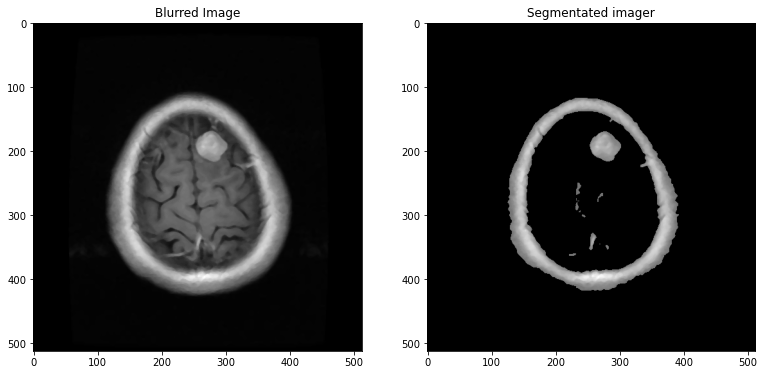

In [123]:
# kernel_size = 5
# image = gilioma_training[0]
# img = cv2.imread(r"D:\project\data\Training\meningioma\Tr-me_0015.jpg", cv2.IMREAD_GRAYSCALE)

# ## median blur
# new_image = cv2.medianBlur(img, kernel_size)
# plt.figure(figsize=(20, 20))
# plt.subplot(231), plt.imshow(new_image, cmap='gray'),plt.title('Blurred Image')

# ## kapur thresholding
# threshold = kapur_threshold(new_image)
# binr = cv2.threshold(new_image, threshold, 255, cv2.THRESH_BINARY)[1]
# plt.subplot(232), plt.imshow(binr, cmap='gray'),plt.title('Segmentated imager')

# ## masking..?n 
# masked1 = cv2.bitwise_and(new_image, new_image, mask=binr)
# plt.subplot(232), plt.imshow(masked1, cmap='gray'),plt.title('Segmentated imager')
# # cv2.imwrite('amasked.jpg', masked1)

# # # adaptive thresholding
# # thresh = cv2.adaptiveThreshold(new_image, 255, 
# #                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
# #                               cv2.THRESH_BINARY, 15, 3)
# # plt.subplot(233), plt.imshow(thresh, cmap='gray'),plt.title('Segmentated imager')

### 1.2 Morpho

(<AxesSubplot:title={'center':'Closing'}>,
 Text(0.5, 1.0, 'Closing'))

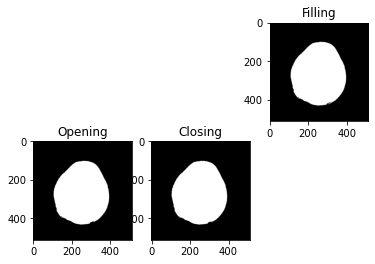

In [110]:
# # binr = cv2.threshold(segmented_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
# # plt.imshow(new_image, cmap='gray')
# # plt.subplot(232), plt.imshow(segmented_image),plt.title('Segmentated imager')

# # define the kernel
# kernel = np.identity(3, np.uint8)
  
    
# ## FILLING
# binr_cp = binr.copy()
 
# # Mask used to flood filling.
# # Notice the size needs to be 2 pixels than the image.
# h, w = binr.shape[:2]
# mask = np.zeros((h+2, w+2), np.uint8)
 
# # Floodfill from point (0, 0)
# cv2.floodFill(binr_cp, mask, (0,0), 255);
 
# # Invert floodfilled image
# binr_cp_inv = cv2.bitwise_not(binr_cp)
 
# # Combine the two images to get the foreground.
# filling = binr | binr_cp_inv
# plt.subplot(233), plt.imshow(filling, cmap='gray'),plt.title('Filling')

# # opening the image
# opening = cv2.morphologyEx(filling, cv2.MORPH_OPEN, kernel, iterations=1)
# plt.subplot(234), plt.imshow(opening, cmap='gray'),plt.title('Opening')
# # closing the image
# closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)
# plt.subplot(235), plt.imshow(closing, cmap='gray'),plt.title('Closing')


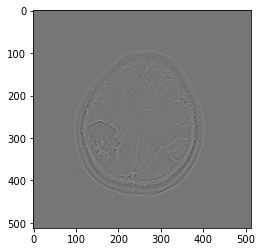

In [103]:
# ## laplacian transformation (for edge)
# laplacian = cv2.Laplacian(new_image,cv2.CV_64F)
# plt.imshow(laplacian, cmap='gray')

In [10]:
# from pythreshold.utils import test_thresholds
# from scipy.misc import ascent